# Mini-projet n° 4 – **RNN, LSTM et GRU vs MLP et CNN**

In [26]:
import torch
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torchmetrics.classification import BinaryF1Score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import time
import hashlib
from transformers import DistilBertTokenizerFast, DistilBertModel
from collections import Counter
import matplotlib.pyplot as plt

Cette section importe tous les packages et librairies nécessaires à l'exécution des cellules qui suivent.

*Note : Si vous utilisez `Docker`, une image de base avec un fichier `requirements.txt` est fournie.*

Ici, on récupère le jeu de données [IMDB](https://ai.stanford.edu/~amaas/data/sentiment/). La partie labélisée va nous permettre de faire une étude de sentiments (positif ou négatif).

In [2]:
# Takes a long time...
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip > /dev/null 2>&1

--2024-12-18 16:11:20--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-18 16:11:21--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M   381KB/s    in 37m 18s 

2024-12-18 16:48:40 (376 KB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



Les quelques hyper-paramètres utiles pour la suite et qu'on a cherché à optimiser. On détaillera ce point un peu plus tard.

In [2]:
# Global variables
BATCH_SIZE = 8
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1
DROPOUT = 0.2
NUM_LAYERS = 2
NUM_EPOCHS = 5
LEARNING_RATE = 1e-3
GLOVE_PATH = "glove.6B.100d.txt"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


## **Construction du vocabulaire basique**

L'intérêt de cette fonction est d'itérer sur toutes les données du jeu de `train` et de les *tokenizer* pour un `tokenizer` donné.

In [3]:
# Build vocab
def yield_tokens(data_iter, tokenizer, model_name='basic'):
    if model_name == 'basic':
        for _, text in data_iter:
            yield tokenizer(text)

train_iter = IMDB(split='train')

Le `tokenizer` choisi est assez basique. Il réalise quelques transformations sur nos textes anglais.
*   Conversion en minuscules
*   Suppression des ponctuations
*   Découpage par espaces
*   Conservation des mots composés

Notre vocabulaire est ensuite construit et correspond à l'ensemble des `tokens` vus lors des itérations sur le jeu de `train`. On constate que nos textes d'entrainement contiennent ainsi plus de 100 000 `tokens` différents.

*Note : De façon générale, les `tokens` ne correspondent ni à des mots ni à des caractères.*

In [4]:
# Load tokenizer
basic_tokenizer = get_tokenizer("basic_english")
basic_vocab = build_vocab_from_iterator(yield_tokens(train_iter, basic_tokenizer, model_name='basic'), specials=['<unk>'])
basic_vocab.set_default_index(basic_vocab['<unk>'])  # Default index for unknown words
BASIC_VOCAB_SIZE = len(basic_vocab)
BASIC_PAD_IDX = basic_vocab['<unk>'] # 0
print(f"Basic vocab length: {BASIC_VOCAB_SIZE}")

Basic vocab length: 100683


## **Contrôle des données**

Pour éviter tout comportement problématique et éviter de biaiser nos modèles, on a décidé de faire une pré-analyse sur nos données. Concrétement, on vérifie que nos données sont **uniques** et que nos datasets sont **disjoints**.

In [5]:
# Function for calculating a unique hash for each data item
def hash_data(data):
    _, text = data
    return hashlib.md5(text.encode('utf-8')).hexdigest()

# Deletes duplicates in the dataset
def remove_duplicates(data):
    seen = set()
    unique_data = []
    for item in data:
        data_hash = hash_data(item)
        if data_hash not in seen:
            seen.add(data_hash)
            unique_data.append(item)
    return unique_data

def verify_no_overlap(train_datas, val_datas, test_datas, hash_fn):
    # Hashes calculations
    train_hashes = set(hash_fn(data) for data in train_datas)
    val_hashes = set(hash_fn(data) for data in val_datas)
    test_hashes = set(hash_fn(data) for data in test_datas)

    assert train_hashes.isdisjoint(val_hashes), "Overlap between train and validation"
    assert train_hashes.isdisjoint(test_hashes), "Overlap between train and test"
    assert val_hashes.isdisjoint(test_hashes), "Overlap between validation and test"

    print("The data sets are well disjointed.")

In [6]:
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')
all_data = list(train_iter) + list(test_iter)
all_data = remove_duplicates(all_data)
all_hashes = [hash_data(data) for data in all_data]

# Check for duplicates
if len(all_hashes) != len(set(all_hashes)):
    print("Caution: Duplicate data exists!")
else:
    print("All data is unique.")

All data is unique.


In [7]:
TRAIN_SIZE = int(0.8 * len(all_data))
VAL_SIZE = int(0.1 * len(all_data))
TEST_SIZE = len(all_data) - TRAIN_SIZE - VAL_SIZE

train_datas, val_datas, test_datas = random_split(all_data, [TRAIN_SIZE, VAL_SIZE, TEST_SIZE])
verify_no_overlap(train_datas, val_datas, test_datas, hash_fn=hash_data) # Useless if we called 'remove_duplicates' previously

The data sets are well disjointed.


## **Analyse exploratoire**

### Répartition des données de `train` et de `test`

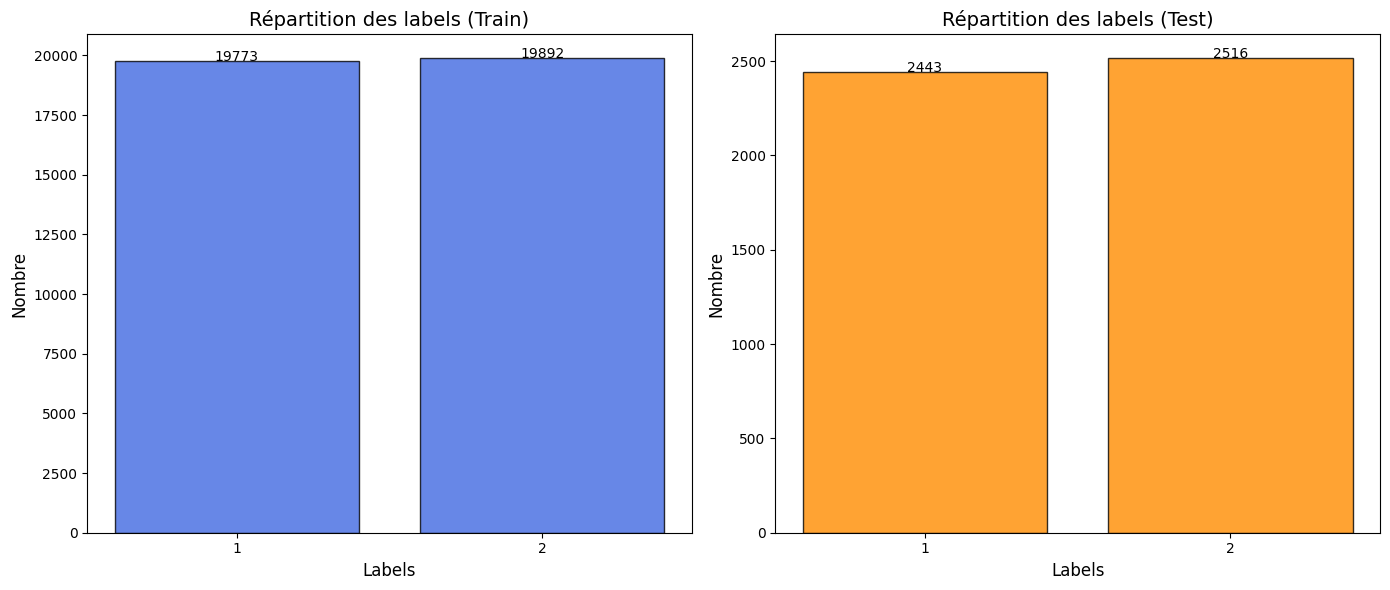

In [8]:
# Distribution des labels
train_labels = [label for label, _ in train_datas]
test_labels = [label for label, _ in test_datas]

train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Création des sous-plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Répartition des labels (train)
axes[0].bar(train_label_counts.keys(), train_label_counts.values(), color='royalblue', alpha=0.8, edgecolor='black')
axes[0].set_title('Répartition des labels (Train)', fontsize=14)
axes[0].set_xlabel('Labels', fontsize=12)
axes[0].set_ylabel('Nombre', fontsize=12)
axes[0].set_xticks(list(train_label_counts.keys()))
axes[0].tick_params(axis='both', which='major', labelsize=10)
for i, v in enumerate(train_label_counts.values()):
    axes[0].text(list(train_label_counts.keys())[i], v + 0.5, str(v), ha='center', fontsize=10)

# Répartition des labels (test)
axes[1].bar(test_label_counts.keys(), test_label_counts.values(), color='darkorange', alpha=0.8, edgecolor='black')
axes[1].set_title('Répartition des labels (Test)', fontsize=14)
axes[1].set_xlabel('Labels', fontsize=12)
axes[1].set_ylabel('Nombre', fontsize=12)
axes[1].set_xticks(list(test_label_counts.keys()))
axes[1].tick_params(axis='both', which='major', labelsize=10)
for i, v in enumerate(test_label_counts.values()):
    axes[1].text(list(test_label_counts.keys())[i], v + 0.5, str(v), ha='center', fontsize=10)

# Ajustements finaux
plt.tight_layout()
plt.show()

Nos jeux de données possèdent donc (presque) autant de textes avec des sentiments positifs, que négatifs.

*Note : Ici le 2 correspond aux textes aux sentiments positifs et 1 aux négatifs. On ramène plus tard lors de la création des `DataLoaders` les valeurs entre 1 et 0.*

### Longueur des textes

Il est pertinent de regarder la taille des textes pour choisir plus tard un modèle. On sait que si l'information associée aux sentiments est contenue par les mots en début de texte, et que nos textes sont longs, il vaut mieux privilégier des LSTM/GRU plutôt que des RNN.

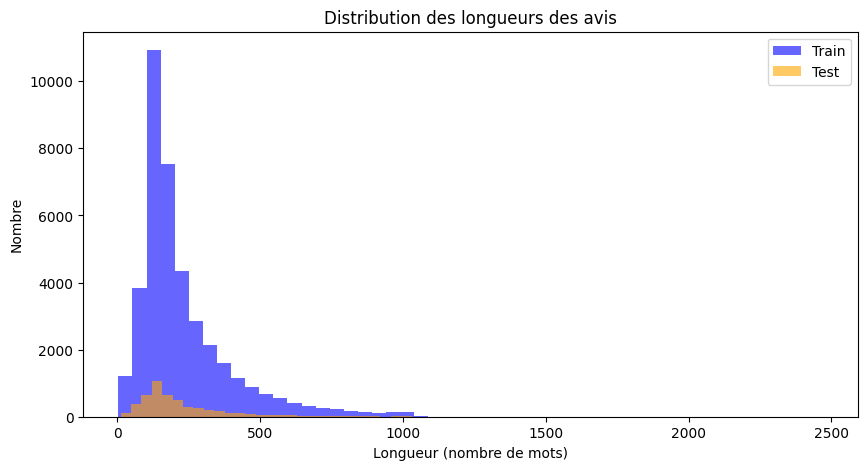

In [9]:
# Fonction pour calculer la longueur des avis
def review_lengths(data):
    return [len(review.split()) for _, review in data]

train_lengths = review_lengths(train_datas)
test_lengths = review_lengths(test_datas)

plt.figure(figsize=(10, 5))
plt.hist(train_lengths, bins=50, alpha=0.6, label='Train', color='blue')
plt.hist(test_lengths, bins=50, alpha=0.6, label='Test', color='orange')
plt.title('Distribution des longueurs des avis')
plt.xlabel('Longueur (nombre de mots)')
plt.ylabel('Nombre')
plt.legend()
plt.show()

Sur la figure, il faut s'intéresser à la plage de valeurs en abscisse et non au nombre d'occurrences. On constate alors que les jeux de `train` et de `test` ont des textes de longueurs comparables. Ceci est une bonne nouvelle pour l'évaluation de la performance de nos modèles.

### Longueur des textes associés aux sentiments

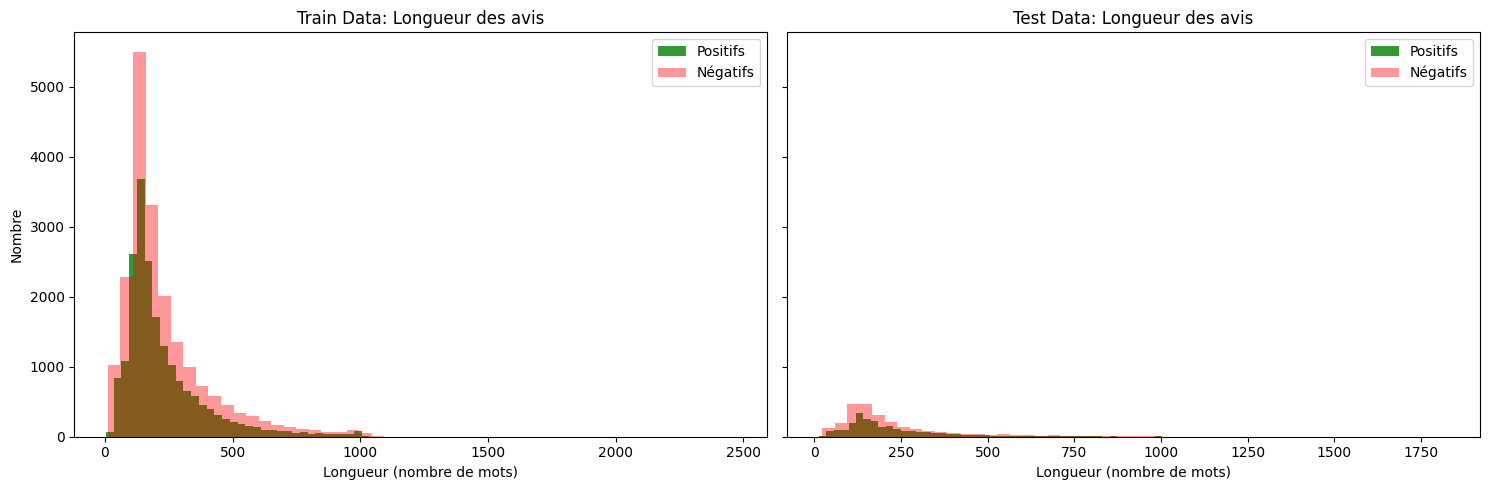

In [10]:
# Calcul des longueurs des avis positifs et négatifs dans les données d'entraînement
pos_lengths_train = [len(review.split()) for label, review in train_datas if label == 1]
neg_lengths_train = [len(review.split()) for label, review in train_datas if label == 2]

# Calcul des longueurs des avis positifs et négatifs dans les données de test
pos_lengths_test = [len(review.split()) for label, review in test_datas if label == 1]
neg_lengths_test = [len(review.split()) for label, review in test_datas if label == 2]

# Création des graphes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Graphe des données d'entraînement
axes[0].hist(pos_lengths_train, bins=50, alpha=0.8, label='Positifs', color='green')
axes[0].hist(neg_lengths_train, bins=50, alpha=0.4, label='Négatifs', color='red')
axes[0].set_title('Train Data: Longueur des avis')
axes[0].set_xlabel('Longueur (nombre de mots)')
axes[0].set_ylabel('Nombre')
axes[0].legend()

# Graphe des données de test
axes[1].hist(pos_lengths_test, bins=50, alpha=0.8, label='Positifs', color='green')
axes[1].hist(neg_lengths_test, bins=50, alpha=0.4, label='Négatifs', color='red')
axes[1].set_title('Test Data: Longueur des avis')
axes[1].set_xlabel('Longueur (nombre de mots)')
axes[1].legend()

plt.tight_layout()
plt.show()

Une fois encore, on constate que les avis associés aux sentiments positifs sont de longueurs environ équivalentes à celles des avis aux sentiments négatifs. On note tout de même que les avis négatifs sont globalement un peu plus courts que ceux positifs (en sachant qu'il y a environ autant d'avis positifs que négatifs). 

Ces différentes analyses nous autorisent à travailler avec des `loss`non pondérées selon la classe (`FocalLoss`).

## **Création des `DataLoaders`**

### Basic

Cette fonction permet de préparer nos données avant d'être utilisées pour construire nos `loaders`. Elle recentre nos labels entre 0 et 1 et fournit pour chaque texte une liste d'indices. Ces indices correspondent à ceux des `tokens` du texte en question dans le vocabulaire précédemment construit.

In [11]:
def basic_collate_batch(batch):
    text_list, label_list = [], []
    for label, text in batch:
        text_list.append(torch.tensor(basic_vocab(basic_tokenizer(text)), dtype=torch.int32))
        label_list.append(label-1)
    text_tensor = pad_sequence(text_list, batch_first=True, padding_value=BASIC_PAD_IDX)
    label_tensor = torch.tensor(label_list, dtype=torch.float32)
    return text_tensor, label_tensor

In [12]:
basic_train_loader = DataLoader(train_datas, batch_size=BATCH_SIZE, shuffle=True, collate_fn=basic_collate_batch, drop_last=True)
basic_val_loader = DataLoader(val_datas, batch_size=BATCH_SIZE, shuffle=True, collate_fn=basic_collate_batch, drop_last=False)
basic_test_loader = DataLoader(test_datas, batch_size=1, shuffle=False, collate_fn=basic_collate_batch, drop_last=False)

# Print loaders' sizes
print(f"Size train loader : {len(basic_train_loader.dataset)}")
print(f"Size validation loader : {len(basic_val_loader.dataset)}")
print(f"Size test loader : {len(basic_test_loader.dataset)}")

Size train loader : 39665
Size validation loader : 4958
Size test loader : 4959


### Bert

Le principe pour `Bert` est similaire à celui des cellules du dessus. Cependant, comme on utilise un `tokenizer` différent, et un vocabulaire différent, on est contraints de construire de nouveaux `DataLoaders`.

In [13]:
bert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
BERT_PAD_IDX = bert_tokenizer.pad_token_id # 0

def bert_collate_batch(batch):
    text_list, label_list = [], []
    for label, text in batch:
        item = bert_tokenizer(text, truncation=True, return_tensors="pt")  # possible ajout : padding=True
        text_list.append(item["input_ids"].squeeze(0))
        label_list.append(label-1)
    padded_text_ids = pad_sequence(text_list, batch_first=True, padding_value=BERT_PAD_IDX)
    label_list = torch.tensor(label_list, dtype=torch.float32)
    return padded_text_ids, label_list

# Pour avoir le mask d'attention :
# item["attention_mask"]

In [14]:
bert_train_loader = DataLoader(train_datas, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bert_collate_batch, drop_last=True)
bert_val_loader = DataLoader(val_datas, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bert_collate_batch, drop_last=False)
bert_test_loader = DataLoader(test_datas, batch_size=1, shuffle=False, collate_fn=bert_collate_batch, drop_last=False)

# Print loaders' sizes
print(f"Size train loader : {len(bert_train_loader.dataset)}")
print(f"Size validation loader : {len(bert_val_loader.dataset)}")
print(f"Size test loader : {len(bert_test_loader.dataset)}")

Size train loader : 39665
Size validation loader : 4958
Size test loader : 4959


## **Chargement d'embedings pré-entrainés**

A chacun de nos `tokens`, on va faire correspondre un vecteur d'*embedings*. Il est possible pour le modèle d'apprendre ces vecteurs, ou bien encore d'en récupérer des existants. C'est ce que réalisent les deux cellules qui suivent. On récupère d'une part les *Glove embedings* et d'autre part les *Bert embedings*. Ces derniers sont à utiliser avec les `DataLoaders` correspondants.

### Glove

In [15]:
def load_glove_embeddings(vocab, path=GLOVE_PATH, embedding_dim=EMBEDDING_DIM):
    # Load GloVe embeddings into a dictionary
    glove_embeddings = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:embedding_dim+1]], dtype=torch.float32) # works if we choose an emb dim < 100
            glove_embeddings[word] = vector

    # Create a weights matrix for words in vocab
    weights_matrix = torch.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.get_stoi().items():
        if word in glove_embeddings:
            weights_matrix[idx] = glove_embeddings[word]
        else:
            weights_matrix[idx] = torch.zeros(embedding_dim)
    return weights_matrix

GLOVE_EMBS = load_glove_embeddings(basic_vocab)
print(GLOVE_EMBS.shape)

torch.Size([100683, 100])


### Bert

In [16]:
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")
BERT_EMBS = bert_model.embeddings.word_embeddings.weight
BERT_EMB_SIZE = 768
print(BERT_EMBS.shape)

torch.Size([30522, 768])


## **Définition de nos modèles**

### MLP

In [17]:
class MLPClassifier(nn.Module):
    def __init__(self, vocab_size=BASIC_VOCAB_SIZE, embed_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM, output_size=OUTPUT_DIM, dropout=DROPOUT, pretrained_embs=None, pretrained=False):
        super(MLPClassifier, self).__init__()

        # Embedding layer
        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.fc1 = nn.Linear(embed_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)

        self.dropout = nn.Dropout(dropout)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_size)
        x = embedded.mean(dim=1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return self.sigmoid(x)

### CNN 1D

In [18]:
class CNN1DClassifier(nn.Module):
    def __init__(self, vocab_size=BASIC_VOCAB_SIZE, embed_size=EMBEDDING_DIM, pretrained_embs=None, pretrained=False):
        super(CNN1DClassifier, self).__init__()

        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.conv1 = nn.Conv1d(in_channels=embed_size, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(DROPOUT)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        embedded = embedded.permute(0, 2, 1)  # Convert to (batch_size, embed_size, seq_len) for Conv1D

        x = self.relu(self.conv1(embedded))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        # Global max pooling
        x = F.adaptive_max_pool1d(x, 1).squeeze(2)  # Shape: (batch_size, out_channels)

        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return self.sigmoid(x)

### RNN

In [19]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size = BASIC_VOCAB_SIZE, embed_size = EMBEDDING_DIM, hidden_size = HIDDEN_DIM, output_size = OUTPUT_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT, pretrained_embs=None,
                  pretrained=False):
        super(RNNClassifier, self).__init__()

        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.add_fc = False
        if pretrained and pretrained_embs.size(1) != embed_size:
            self.fc1 = nn.Linear(pretrained_embs.size(1), embed_size)
            self.add_fc = True

        self.rnn = nn.RNN(embed_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True, nonlinearity='tanh')
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        if self.add_fc:
            embedded = self.fc1(embedded)

        rnn_out, hidden = self.rnn(embedded)
        last_hidden_state = hidden[-1]
        output = self.fc2(last_hidden_state)
        return self.sigmoid(output)


### LSTM

In [20]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size=BASIC_VOCAB_SIZE, embed_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM,
                 output_size=OUTPUT_DIM, dropout=DROPOUT, num_layers=NUM_LAYERS, pretrained_embs=GLOVE_EMBS, pretrained=False):
        super(LSTMClassifier, self).__init__()
        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True) # To ensure weights are not trained
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.add_fc = False
        if pretrained and pretrained_embs.size(1) != embed_size:
            self.fc1 = nn.Linear(pretrained_embs.size(1), embed_size)
            self.add_fc = True

        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        if self.add_fc:
            embedded = self.fc1(embedded)
        lstm_out, (hidden, _) = self.lstm(embedded)
        output = self.fc2(hidden[-1])
        return self.sigmoid(output)

### GRU

In [21]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size=BASIC_VOCAB_SIZE, embed_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM,
                 output_size=OUTPUT_DIM, dropout=DROPOUT, num_layers=NUM_LAYERS, pretrained_embs=GLOVE_EMBS, pretrained=False):
        super(GRUClassifier, self).__init__()
        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True) # To ensure weights are not trained
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.add_fc = False
        if pretrained and pretrained_embs.size(1) != embed_size:
            self.fc1 = nn.Linear(pretrained_embs.size(1), embed_size)
            self.add_fc = True

        self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layers,
                          dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        if self.add_fc:
            embedded = self.fc1(embedded)
        gru_out, _ = self.gru(embedded)
        last_hidden_state = gru_out[:, -1, :]
        output = self.fc2(last_hidden_state)
        return self.sigmoid(output)

## **Fonctions de `test` et de `train`**

In [22]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Train function
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_loss, total_acc = 0, 0
    size_loader = 0
    f1_metric = BinaryF1Score().to(DEVICE)
    for text, labels in tqdm(data_loader):
        text, labels = text.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        output = model(text).squeeze(dim=1) # could use .squeeze() if drop_last=True
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Metrics part
        total_loss += loss.item()
        preds = (output >= 0.5)
        total_acc += (preds == labels).sum().item()
        f1_metric.update(preds, labels)
        size_loader += labels.size(0)

    f1 = f1_metric.compute()
    f1_metric.reset()
    return total_loss / size_loader, total_acc / size_loader, f1

# Test function
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    size_loader = 0
    f1_metric = BinaryF1Score().to(DEVICE)
    with torch.no_grad():
        for text, labels in tqdm(data_loader):
            text, labels = text.to(DEVICE), labels.to(DEVICE)
            output = model(text).squeeze(dim=1)
            loss = criterion(output, labels)

            # Metrics part
            total_loss += loss.item()
            preds = (output >= 0.5)
            total_acc += (preds == labels).sum().item()
            f1_metric.update(preds, labels)
            size_loader += labels.size(0)

    f1 = f1_metric.compute()
    f1_metric.reset()
    return total_loss / size_loader, total_acc / size_loader, f1

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## **MLP**

### Basic

Number of trainable params: 10089549


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.4771 | Train Acc: 0.7464 | Train F1: 0.7556 | Val Loss: 0.4566 | Val Acc: 0.7775 | Val F1: 0.8124 | Time: 33.22s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/5 | Train Loss: 0.2808 | Train Acc: 0.8865 | Train F1: 0.8873 | Val Loss: 0.3190 | Val Acc: 0.8594 | Val F1: 0.8713 | Time: 35.01s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/5 | Train Loss: 0.2228 | Train Acc: 0.9126 | Train F1: 0.9132 | Val Loss: 0.2537 | Val Acc: 0.8994 | Val F1: 0.9026 | Time: 36.52s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 4/5 | Train Loss: 0.1806 | Train Acc: 0.9332 | Train F1: 0.9336 | Val Loss: 0.2667 | Val Acc: 0.8996 | Val F1: 0.8983 | Time: 35.09s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 5/5 | Train Loss: 0.1512 | Train Acc: 0.9447 | Train F1: 0.9450 | Val Loss: 0.2905 | Val Acc: 0.8907 | Val F1: 0.8960 | Time: 35.19s


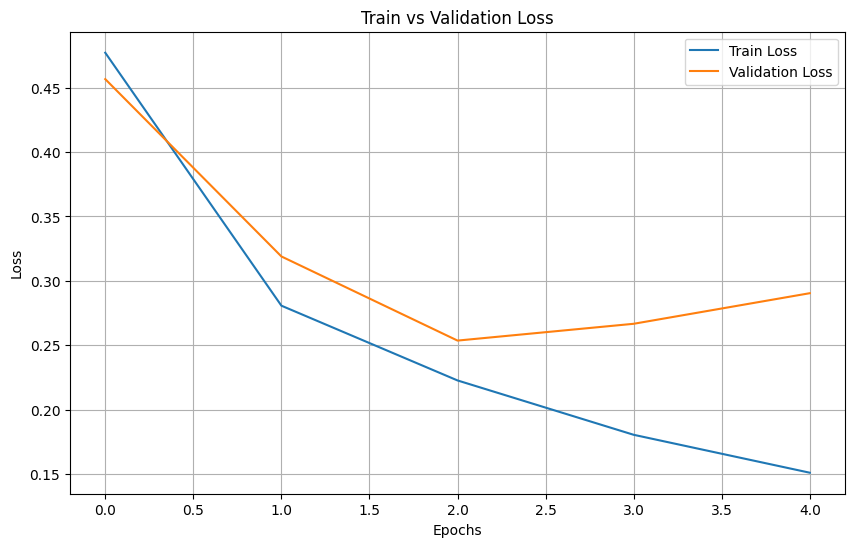

In [23]:
model_mlp = MLPClassifier(pretrained=False)
model_mlp.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_mlp.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_mlp)}")
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_mlp, basic_train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_mlp, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

In [24]:
test_loss, test_acc_mlp, test_f1_mlp = evaluate(model_mlp, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_mlp:.4f}, F1 Score: {test_f1_mlp:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 0.4393, Accuracy: 0.9103, F1 Score: 0.9148


## CNN 1D

### Basic

Number of trainable params: 10312141


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/3 | Train Loss: 0.4893 | Train Acc: 0.7478 | Train F1: 0.7572 | Val Loss: 0.3428 | Val Acc: 0.8479 | Val F1: 0.8479 | Time: 71.73s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/3 | Train Loss: 0.2930 | Train Acc: 0.8780 | Train F1: 0.8792 | Val Loss: 0.3315 | Val Acc: 0.8590 | Val F1: 0.8711 | Time: 65.26s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/3 | Train Loss: 0.2083 | Train Acc: 0.9197 | Train F1: 0.9201 | Val Loss: 0.2735 | Val Acc: 0.8901 | Val F1: 0.8884 | Time: 65.15s


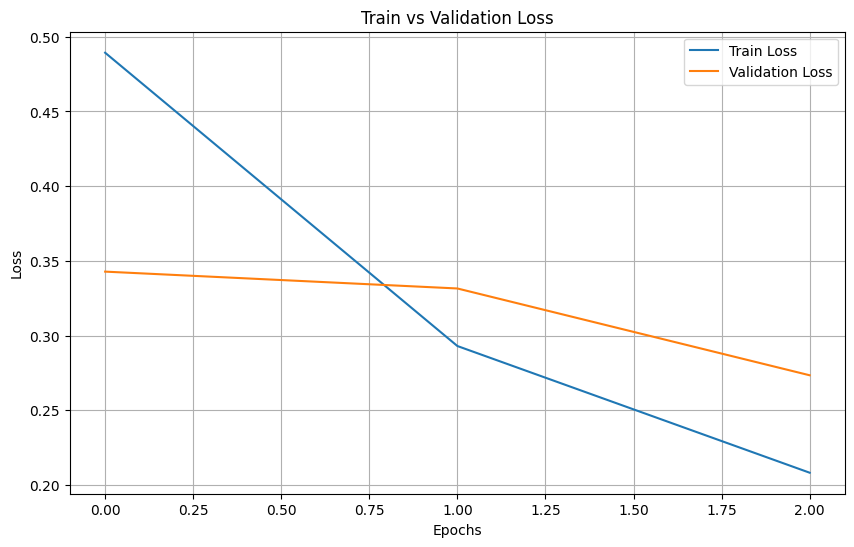

In [33]:
model_cnn = CNN1DClassifier(pretrained=False)
model_cnn.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_cnn.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_cnn)}")
train_losses = []
val_losses = []
epochs = 3
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_cnn, basic_train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_cnn, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

In [34]:
test_loss, test_acc_cnn, test_f1_cnn = evaluate(model_cnn, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_cnn:.4f}, F1 Score: {test_f1_cnn:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 0.2574, Accuracy: 0.8941, F1 Score: 0.8945


## RNN

### Basic

Number of trainable params: 10130893


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/1 | Train Loss: 0.6981 | Train Acc: 0.5034 | Train F1: 0.5049 | Val Loss: 0.6934 | Val Acc: 0.4988 | Val F1: 0.6644 | Time: 45.20s


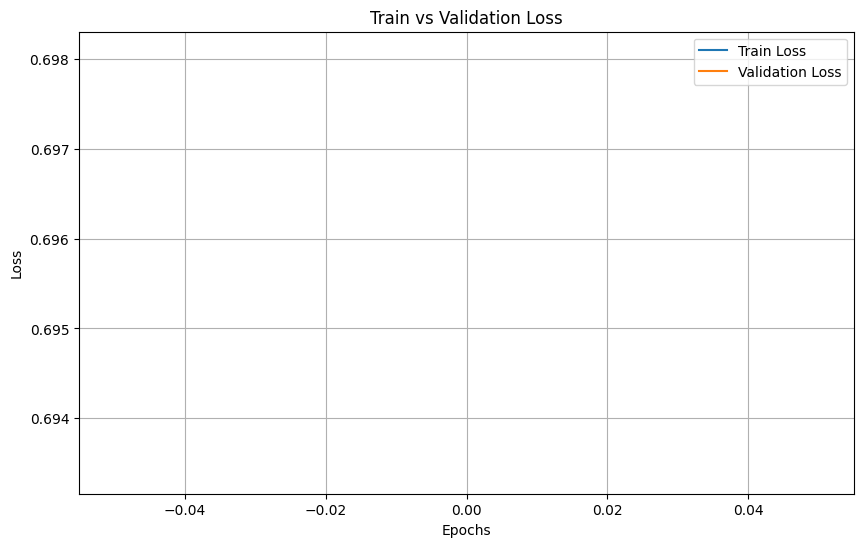

In [37]:
model_rnn = RNNClassifier(pretrained=False)
model_rnn.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_rnn.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_rnn)}")
train_losses = []
val_losses = []
epochs = 1
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_rnn, basic_train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_rnn, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

In [38]:
test_loss, test_acc_rnn, test_f1_rnn = evaluate(model_rnn, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_rnn:.4f}, F1 Score: {test_f1_rnn:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 0.6930, Accuracy: 0.5090, F1 Score: 0.6580


### Bert

In [41]:
model = RNNClassifier(pretrained=True, pretrained_embs=BERT_EMBS, embed_size=BERT_EMB_SIZE)
model.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model)}")

epochs = 1
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model, bert_train_loader, criterion, optimizer)
    val_loss, val_acc, val_f1 = evaluate(model, bert_val_loader, criterion)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")

Number of trainable params: 148097


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/1 | Train Loss: 0.6982 | Train Acc: 0.5036 | Train F1: 0.5035 | Val Loss: 0.7404 | Val Acc: 0.4994 | Val F1: 0.6661 | Time: 68.45s


## LSTM

### Basic

Number of trainable params: 10318285


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/4 | Train Loss: 0.6926 | Train Acc: 0.5056 | Train F1: 0.5171 | Val Loss: 0.6898 | Val Acc: 0.5163 | Val F1: 0.1793 | Time: 104.50s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/4 | Train Loss: 0.6562 | Train Acc: 0.5751 | Train F1: 0.5570 | Val Loss: 0.5434 | Val Acc: 0.7275 | Val F1: 0.7064 | Time: 99.87s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/4 | Train Loss: 0.3693 | Train Acc: 0.8447 | Train F1: 0.8456 | Val Loss: 0.2843 | Val Acc: 0.8883 | Val F1: 0.8906 | Time: 89.84s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 4/4 | Train Loss: 0.2265 | Train Acc: 0.9150 | Train F1: 0.9158 | Val Loss: 0.2496 | Val Acc: 0.9002 | Val F1: 0.9012 | Time: 89.57s


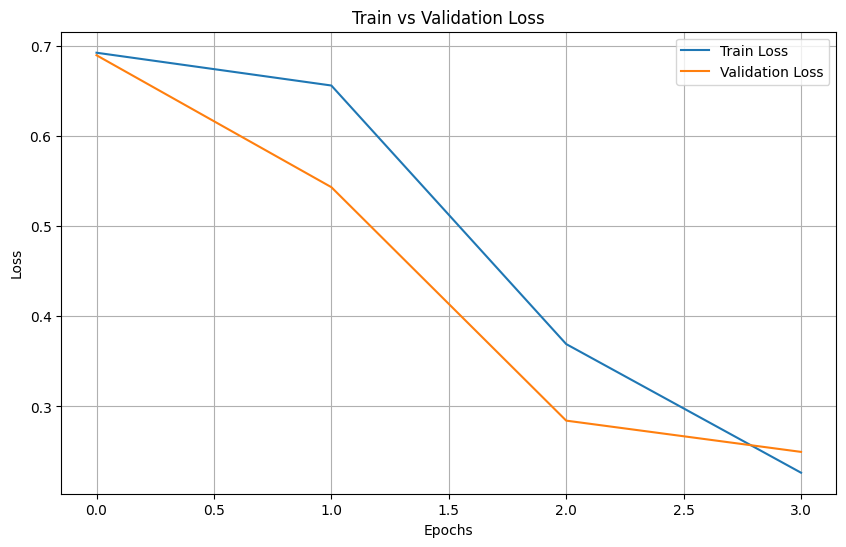

In [44]:
model_lstm = LSTMClassifier(pretrained=False)
model_lstm.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_lstm)}")
train_losses = []
val_losses = []
epochs = 4
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_lstm, basic_train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_lstm, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

In [45]:
test_loss, test_acc_lstm, test_f1_lstm = evaluate(model_lstm, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_lstm:.4f}, F1 Score: {test_f1_lstm:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 0.2617, Accuracy: 0.9022, F1 Score: 0.9062


### Bert

In [47]:
model = LSTMClassifier(pretrained=True, pretrained_embs=BERT_EMBS, embed_size=BERT_EMB_SIZE)
model.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model)}")

epochs = 1
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model, bert_train_loader, criterion, optimizer)
    val_loss, val_acc, val_f1 = evaluate(model, bert_val_loader, criterion)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")

Number of trainable params: 592001


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/1 | Train Loss: 0.6934 | Train Acc: 0.4996 | Train F1: 0.5242 | Val Loss: 0.6931 | Val Acc: 0.5036 | Val F1: 0.2665 | Time: 104.44s


## GRU

### Basic

Number of trainable params: 10255821


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/3 | Train Loss: 0.6859 | Train Acc: 0.5266 | Train F1: 0.5373 | Val Loss: 0.7618 | Val Acc: 0.5944 | Val F1: 0.3422 | Time: 60.83s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/3 | Train Loss: 0.2993 | Train Acc: 0.8720 | Train F1: 0.8728 | Val Loss: 0.2266 | Val Acc: 0.9064 | Val F1: 0.9084 | Time: 62.41s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/3 | Train Loss: 0.1517 | Train Acc: 0.9434 | Train F1: 0.9436 | Val Loss: 0.2158 | Val Acc: 0.9171 | Val F1: 0.9179 | Time: 66.48s


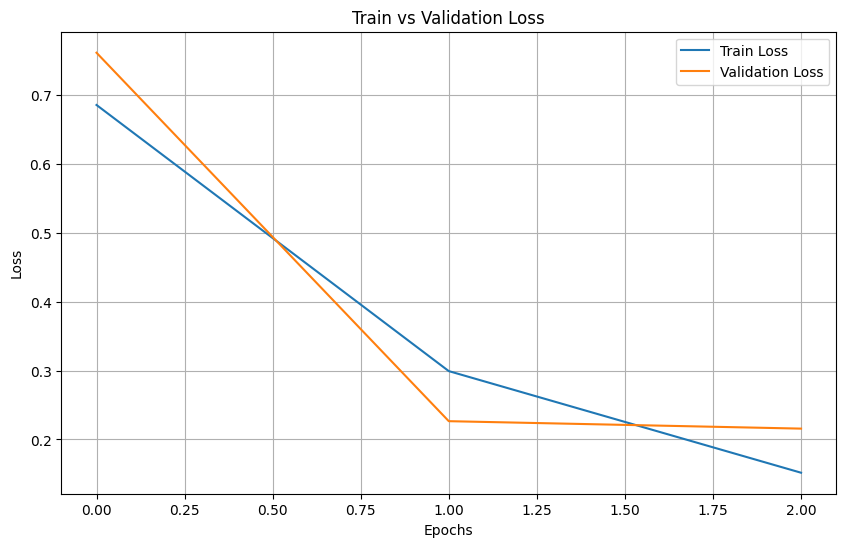

In [48]:
model_gru = GRUClassifier(pretrained=False)
model_gru.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_gru.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_gru)}")
train_losses = []
val_losses = []
epochs = 3
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_gru, basic_train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_gru, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

In [49]:
test_loss, test_acc_gru, test_f1_gru = evaluate(model_gru, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_gru:.4f}, F1 Score: {test_f1_gru:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 0.2111, Accuracy: 0.9181, F1 Score: 0.9205


### Bert

In [50]:
model = GRUClassifier(pretrained=True, pretrained_embs=BERT_EMBS, embed_size=BERT_EMB_SIZE)
model.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model)}")

epochs = 1
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model, bert_train_loader, criterion, optimizer)
    val_loss, val_acc, val_f1 = evaluate(model, bert_val_loader, criterion)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")

Number of trainable params: 444033


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/1 | Train Loss: 0.6939 | Train Acc: 0.4966 | Train F1: 0.4816 | Val Loss: 0.6932 | Val Acc: 0.5012 | Val F1: 0.2633 | Time: 80.95s


## **Modèle Global**

In [51]:
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        predictions = []
        for model in self.models:
            model.eval()
            with torch.no_grad():
                outputs = model(x)
                predictions.append((outputs >= 0.5).float())

        predictions = torch.stack(predictions, dim=0)  # Shape: (num_models, batch_size)
        majority_vote = predictions.sum(dim=0) >= (len(self.models) / 2)
        return majority_vote.float()

In [53]:
models = [model_mlp, model_cnn, model_rnn, model_gru, model_lstm]
ensemble_model = EnsembleModel(models)

# Évaluez le modèle ensemble
test_loss, test_acc_ensemble, test_f1_ensemble = evaluate(ensemble_model, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_ensemble:.4f}, F1 Score: {test_f1_ensemble:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 7.4209, Accuracy: 0.9258, F1 Score: 0.9293


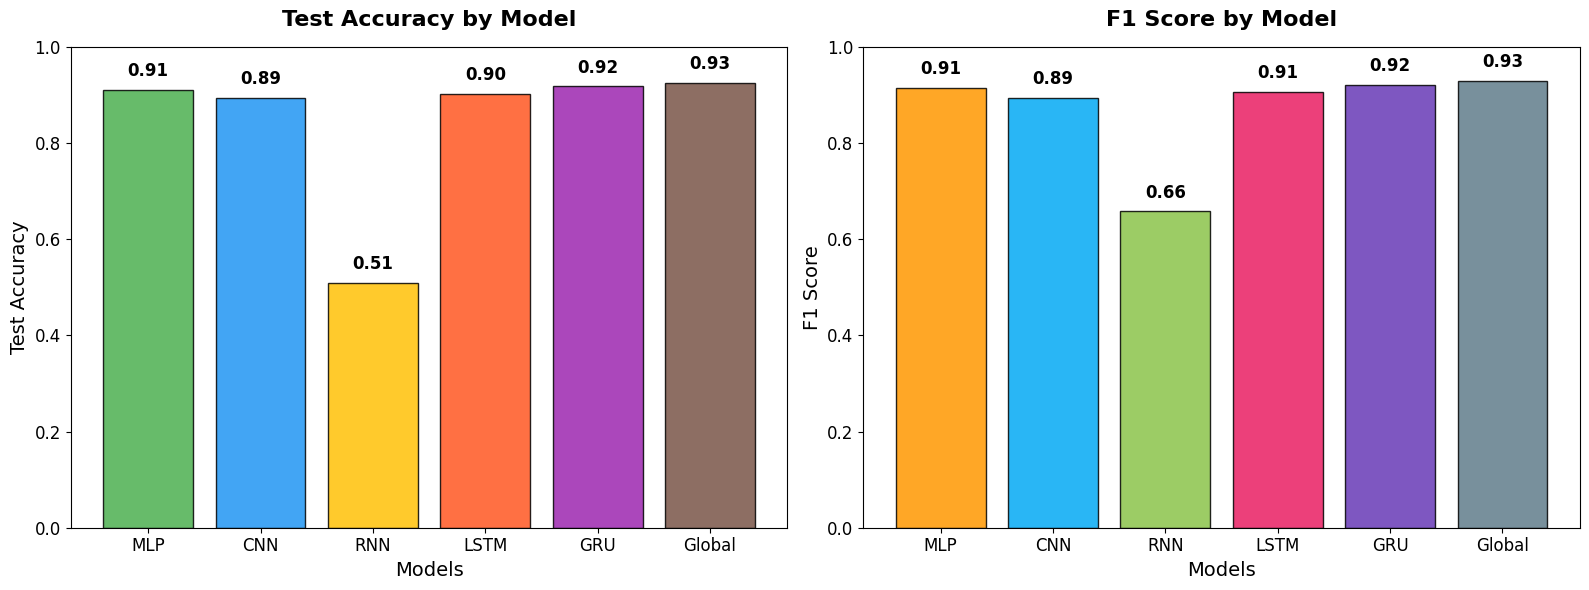

In [58]:
model_list = ['MLP', 'CNN', 'RNN', 'LSTM', 'GRU','Global']
test_scores = [test_acc_mlp.cpu().item() if hasattr(test_acc_mlp, "cpu") else test_acc_mlp,
               test_acc_cnn.cpu().item() if hasattr(test_acc_cnn, "cpu") else test_acc_cnn,
               test_acc_rnn.cpu().item() if hasattr(test_acc_rnn, "cpu") else test_acc_rnn,
               test_acc_lstm.cpu().item() if hasattr(test_acc_lstm, "cpu") else test_acc_lstm,
               test_acc_gru.cpu().item() if hasattr(test_acc_gru, "cpu") else test_acc_gru,
               test_acc_ensemble.cpu().item() if hasattr(test_acc_ensemble, "cpu") else test_acc_ensemble]

f1_scores = [test_f1_mlp.cpu().item() if hasattr(test_f1_mlp, "cpu") else test_f1_mlp,
             test_f1_cnn.cpu().item() if hasattr(test_f1_cnn, "cpu") else test_f1_cnn,
             test_f1_rnn.cpu().item() if hasattr(test_f1_rnn, "cpu") else test_f1_rnn,
             test_f1_lstm.cpu().item() if hasattr(test_f1_lstm, "cpu") else test_f1_lstm,
             test_f1_gru.cpu().item() if hasattr(test_f1_gru, "cpu") else test_f1_gru,
             test_f1_ensemble.cpu().item() if hasattr(test_f1_ensemble, "cpu") else test_f1_ensemble]

# Création des plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Couleurs pour les barres
colors_test_scores = ['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0', '#795548']
colors_f1_scores = ['#FF9800', '#03A9F4', '#8BC34A', '#E91E63', '#673AB7', '#607D8B']

# Premier plot : Test Accuracy
bars1 = axes[0].bar(model_list, test_scores, color=colors_test_scores, edgecolor='black', alpha=0.85)
axes[0].set_title('Test Accuracy by Model', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Models', fontsize=14)
axes[0].set_ylabel('Test Accuracy', fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='both', which='major', labelsize=12)
for bar, acc in zip(bars1, test_scores):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{acc:.2f}', 
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

# Deuxième plot : F1 Score
bars2 = axes[1].bar(model_list, f1_scores, color=colors_f1_scores, edgecolor='black', alpha=0.85)
axes[1].set_title('F1 Score by Model', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Models', fontsize=14)
axes[1].set_ylabel('F1 Score', fontsize=14)
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='both', which='major', labelsize=12)
for bar, f1 in zip(bars2, f1_scores):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{f1:.2f}', 
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

# Ajustement du layout
plt.tight_layout()
plt.show()